In [65]:
%matplotlib notebook

import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import socket
import getpass
import pandas as pd
import xml.etree.ElementTree as ET
import nntools as nt

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [67]:
print(torch.__version__)

1.1.0


In [68]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'

In [69]:
class VOCDataset(td.Dataset):
    def __init__(self, root_dir, mode='train', image_size=(800, 800)): 
        super(VOCDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        
        self.images_dir = os.path.join(root_dir, 'JPEGImages')
        self.images_idx = pd.read_csv(os.path.join(root_dir, 'ImageSets/Main' ,"%s.txt" % mode), sep=' ', header=None, error_bad_lines=False) 
        self.ann_dir    = os.path.join(root_dir, 'Annotations')
        
        self.labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']
    def __len__(self):
        # Return the size of the dataset
        return len(self.images_idx)
    def __repr__(self):
        # Return the data is training set or testing set, and its image size
        return "VOCDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        # Return the preprocessed data (tensor) and labels.
        img_path = os.path.join(self.images_dir, self.images_idx.iloc[idx][0]+".jpg") 
        img = Image.open(img_path).convert('RGB')
        objs, seen_labels = self.get_obj(self.images_idx.iloc[idx][0])
        transform = tv.transforms.Compose([ 
            # resize the image
            tv.transforms.Resize(self.image_size), 
            # convert a PIL Image to tensor in range [0,1]
            tv.transforms.ToTensor(), 
            # normalize the tensor to [-1,1]
            #tv.transforms.Normalize((1/2,1/2,1/2),(1/2,1/2,1/2)) 
        ])
        # Transform
        img = transform(img)
        return img, objs, seen_labels
    
    def get_obj(self, img_name):
        
        img = {'object':[]}
        seen_labels = {}
        
        
        
        tree = ET.parse(os.path.join(self.ann_dir, img_name+".xml"))
     
        for elem in tree.iter():
            #print(elem.tag)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
                frac_x = self.image_size[0] / img['width']
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
                frac_y = self.image_size[0] / img['height']
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                for attr in list(elem):
                    
                    if 'name' in attr.tag:          
                        obj['name'] = attr.text
                        
                        img['object'] += [obj]  
 
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                           
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                #obj['xmin'] = int(round(float(dim.text)*frac_x))
                                obj['xmin'] = float(dim.text)*frac_x
                            if 'ymin' in dim.tag:
                                #obj['ymin'] = int(round(float(dim.text)*frac_y))
                                obj['ymin'] = float(dim.text)*frac_y
                            if 'xmax' in dim.tag:
                                #obj['xmax'] = int(round(float(dim.text)*frac_x))
                                obj['xmax'] = float(dim.text)*frac_x
                            if 'ymax' in dim.tag:
                                #obj['ymax'] = int(round(float(dim.text)*frac_y))
                                obj['ymax'] = float(dim.text)*frac_y
                                                                              
        return img, seen_labels
    

In [70]:
def myimshow(image, boxes = [], ax = plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    
    labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'background']
    color = {}
    for i in range(len(labels)):    
        color[labels[i]] = np.random.random(3)
    
    for i in range(len(boxes)):

        ax.gca().add_patch(patches.Rectangle((boxes[i]['xmin'],boxes[i]['ymin']),boxes[i]['xmax']- boxes[i]['xmin'],boxes[i]['ymax']-boxes[i]['ymin'],edgecolor=color[boxes[i]["name"]],facecolor='none'))
        ax.annotate(boxes[i]["name"], xy=(boxes[i]['xmax'], boxes[i]['ymin']),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[boxes[i]["name"]]))
    ax.axis('off') 
   
    return h

In [71]:
train_set = VOCDataset(dataset_root_dir)
val_set = VOCDataset(dataset_root_dir,mode="val")

In [72]:
x, x_objs, x_labels = train_set.__getitem__(1150)

<IPython.core.display.Javascript object>


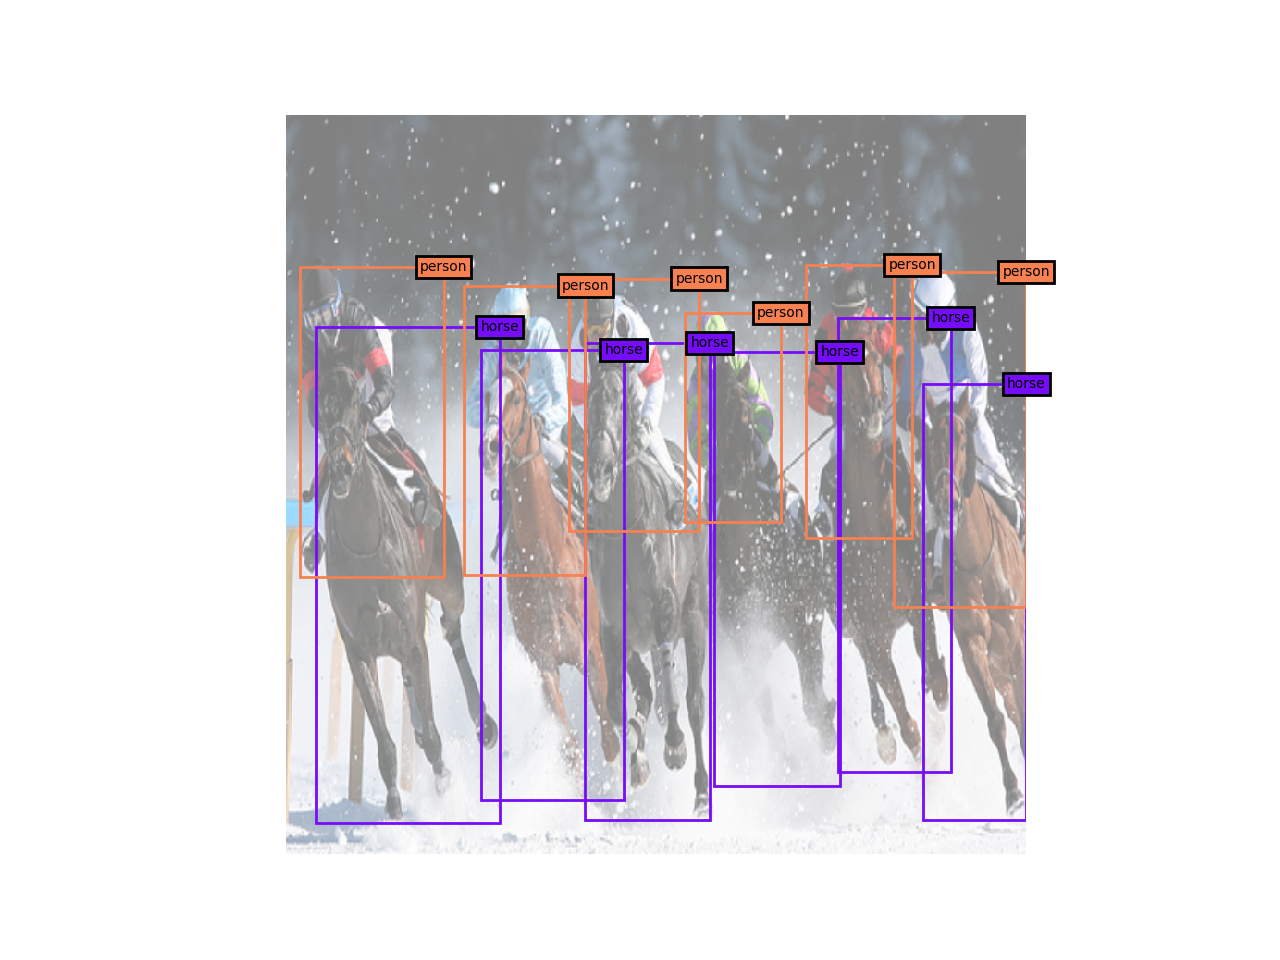

In [73]:
myimshow(x, boxes = x_objs["object"])

In [74]:
x_objs

{'object': [{'name': 'horse',
   'xmin': 32.0,
   'ymin': 228.57142857142856,
   'xmax': 230.4,
   'ymax': 765.2173913043478},
  {'name': 'horse',
   'xmin': 209.60000000000002,
   'ymin': 253.41614906832297,
   'xmax': 364.8,
   'ymax': 740.3726708074533},
  {'name': 'horse',
   'xmin': 323.20000000000005,
   'ymin': 245.96273291925465,
   'xmax': 457.6,
   'ymax': 762.7329192546583},
  {'name': 'horse',
   'xmin': 462.40000000000003,
   'ymin': 255.9006211180124,
   'xmax': 598.4,
   'ymax': 725.4658385093168},
  {'name': 'horse',
   'xmin': 596.8000000000001,
   'ymin': 218.63354037267078,
   'xmax': 718.4000000000001,
   'ymax': 710.5590062111801},
  {'name': 'horse',
   'xmin': 688.0,
   'ymin': 290.6832298136646,
   'xmax': 800.0,
   'ymax': 762.7329192546583},
  {'name': 'person',
   'xmin': 14.4,
   'ymin': 163.9751552795031,
   'xmax': 169.60000000000002,
   'ymax': 499.3788819875776},
  {'name': 'person',
   'xmin': 192.0,
   'ymin': 183.85093167701862,
   'xmax': 323.2000000

In [75]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

In [76]:
class Fasterrcnn_resnet50_Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(Fasterrcnn_resnet50_Transfer, self).__init__()
        self.model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = fine_tuning
            
        cls_score_num_ftrs = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor.cls_score = nn.Linear(cls_score_num_ftrs, num_classes+1)
        
        bbox_pred_num_ftrs = self.model.roi_heads.box_predictor.bbox_pred.in_features
        self.model.roi_heads.box_predictor.bbox_pred =  nn.Linear(bbox_pred_num_ftrs, 4*(num_classes+1))
        
    def forward(self, x): 
        f = self.model(x)
        return f

In [77]:
model = Fasterrcnn_resnet50_Transfer(20)

In [78]:
model

Fasterrcnn_resnet50_Transfer(
  (cross_entropy): CrossEntropyLoss()
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform()
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace)
            (downsample): Sequential(
              (0): Conv2d(64

In [79]:
train_loader = td.DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)
val_loader = td.DataLoader(val_set, batch_size=1, shuffle=True, pin_memory=True)

In [80]:
model.eval()

Fasterrcnn_resnet50_Transfer(
  (cross_entropy): CrossEntropyLoss()
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform()
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace)
            (downsample): Sequential(
              (0): Conv2d(64

In [81]:
model = model.to(device)
x = x.to(device)

In [20]:
predictions = model([x])

In [88]:
predictions[0]

{'boxes': tensor([[694.1944, 289.7036, 785.6205, 653.0170],
         [440.7126, 254.2744, 473.8892, 288.8907],
         [595.3118, 209.2947, 630.6294, 251.9214],
         [585.0803, 181.3665, 649.2815, 265.2468],
         [ 13.8698, 258.7011, 229.4585, 602.9433],
         [669.6569, 256.1098, 748.9651, 631.4413],
         [546.9425, 155.5811, 787.9915, 800.0000],
         [744.0042, 355.8398, 796.3456, 431.7448],
         [271.5854, 312.4984, 315.6399, 418.6412],
         [744.0571, 383.5904, 800.0000, 449.3448],
         [676.7697, 205.3723, 712.0314, 247.8446],
         [645.8719, 234.5465, 800.0000, 755.8052],
         [147.2887, 472.0070, 362.6475, 745.9150],
         [ 42.5648, 519.5809, 253.4495, 764.4346],
         [  0.0000, 496.8019, 214.0682, 757.3727],
         [454.0125, 259.1192, 472.0844, 287.3155],
         [513.9700, 507.9774, 727.4023, 715.6243],
         [544.9617, 300.1578, 758.1155, 562.5499],
         [ 20.7906, 155.8474, 207.1853, 440.8537],
         [178.8902, 42

In [94]:
def myimshow_score(image, boxes = [], ax = plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    
    labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'background']
    color = {}
    for i in range(len(labels)):    
        color[labels[i]] = np.random.random(3)
    
    for i in range(len(boxes)):

        ax.gca().add_patch(patches.Rectangle((boxes[i]['xmin'],boxes[i]['ymin']),boxes[i]['xmax']- boxes[i]['xmin'],boxes[i]['ymax']-boxes[i]['ymin'],edgecolor=color[boxes[i]["name"]],facecolor='none'))
        ax.annotate(boxes[i]["name"]+':'+str(boxes[i]["score"]), xy=(boxes[i]['xmax'], boxes[i]['ymin']),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[boxes[i]["name"]]))
    ax.axis('off') 
   
    return h
def convert(predictions):
    labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                           'bus',        'car',      'cat',  'chair',     'cow',
                           'diningtable','dog',    'horse',  'motorbike', 'person',
                           'pottedplant','sheep',  'sofa',   'train',   'tvmonitor','background']
    x_objs_pred = {"object":[]}
    scores = predictions[0]['scores'].detach().cpu().numpy()
    for i in range(len(predictions[0]['labels'])):
        obj = {}
        boxes = predictions[0]['boxes'][i].detach().cpu().numpy()
        obj['name'] = labels[predictions[0]['labels'][i].detach().cpu().numpy()]
        obj['score'] = scores[i]
        obj['xmin'] = boxes[0]
        obj['ymin'] = boxes[1]
        obj['xmax'] = boxes[2]
        obj['ymax'] = boxes[3]
        #print(obj)
        x_objs_pred["object"]+= [obj]
        
    return x_objs_pred


In [95]:
x_objs_pred = convert(predictions)

<IPython.core.display.Javascript object>


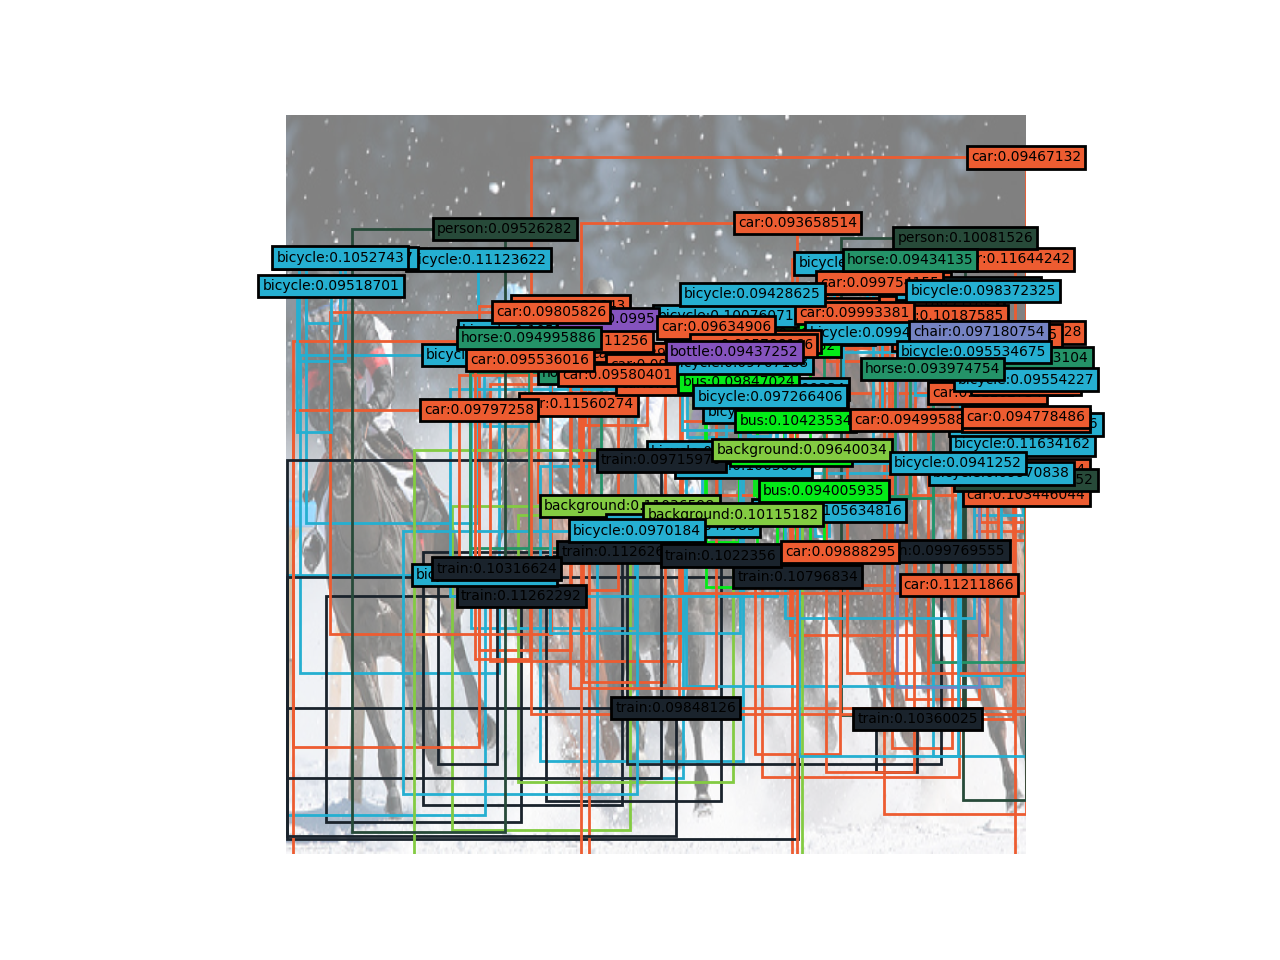

In [96]:
myimshow_score(x, boxes = x_objs_pred["object"])

In [97]:
x_objs_pred

{'object': [{'name': 'car',
   'score': 0.12849607,
   'xmin': 694.1944,
   'ymin': 289.70358,
   'xmax': 785.62054,
   'ymax': 653.01697},
  {'name': 'car',
   'score': 0.12591612,
   'xmin': 440.71255,
   'ymin': 254.27443,
   'xmax': 473.8892,
   'ymax': 288.89075},
  {'name': 'car',
   'score': 0.12088477,
   'xmin': 595.31177,
   'ymin': 209.29468,
   'xmax': 630.6294,
   'ymax': 251.92139},
  {'name': 'car',
   'score': 0.119434185,
   'xmin': 585.0803,
   'ymin': 181.36649,
   'xmax': 649.2815,
   'ymax': 265.24683},
  {'name': 'bicycle',
   'score': 0.118529774,
   'xmin': 13.869774,
   'ymin': 258.7011,
   'xmax': 229.45847,
   'ymax': 602.9433},
  {'name': 'car',
   'score': 0.11810294,
   'xmin': 669.6569,
   'ymin': 256.10983,
   'xmax': 748.96515,
   'ymax': 631.4413},
  {'name': 'car',
   'score': 0.11644242,
   'xmin': 546.9425,
   'ymin': 155.58112,
   'xmax': 787.99146,
   'ymax': 800.0},
  {'name': 'bicycle',
   'score': 0.11634162,
   'xmin': 744.0042,
   'ymin': 355